In [1]:
import numpy as np
from matplotlib import pyplot as plt
from utils import *
import pandas as pd
from scipy import stats

## Firstly, read data from file

In [2]:
filename = 'Data/skeleton_xyz_stage_all.csv'
df = pd.read_csv(filename)

### Read in all the stage data, and group each tubule together

In [3]:
stages = df['Stage'].to_numpy().astype('int')
tubules = df['Tubule_ID'].to_numpy().astype('int')
branches = df['Branch_ID'].to_numpy().astype('int')
refs = df['Ref']

datasets = [] 
for i in range(1, 10): 
    mask = (tubules == i)
    tubule_stage = stages[mask] 
    tubule_branches = branches[mask]
    tubule_refs = refs[mask]
    tubule_dataset = [] 
    for j in range(1, tubule_branches[-1]+1):
        mask = (tubule_branches == j)
        branch_stages = tubule_stage[mask]
        branch_dataset = {
            'start': (tubule_refs[mask]).iloc[0], 
            'end': (tubule_refs[mask]).iloc[-1], 
            'stages': branch_stages,
        }
        tubule_dataset.append(branch_dataset)

    datasets.append(tubule_dataset)      

### Print out the start and end points of each tubule to manually read off the longest section (ish) 

In [4]:
for (i, dataset) in enumerate(datasets): 
    print('tubule ID:', i+1)
    for d in dataset: 
        stages = d['stages']     
        print(d['start'], d['end'], len(stages), np.sum(stages==0), np.sum(stages==255))

tubule ID: 1
b4 b5 1663 7 1
b4 b3 217 0 0
b4 R8 5479 11 41
b5 b6 1362 0 0
b5 R5 3671 10 35
b3 b2 4406 9 13
b3 R2 2830 5 0
b2 R4 1669 2 2
b2 b1 240 0 0
b1 R1 3149 4 37
b1 R3 1503 3 0
b6 R7 3628 3 2
b6 R6 2178 8 17
tubule ID: 2
R3 b1 3507 10 59
b1 R1 5794 15 101
b1 R2 593 17 0
tubule ID: 3
b1 R1 8200 9 77
b1 R3 2731 10 52
b1 R2 702 5 66
tubule ID: 4
b1 b2 4444 3 122
b1 b3 2495 3 52
b1 R2 3261 6 11
b2 R6 884 3 0
b2 R8 1167 7 6
b6 R4 1318 3 25
b6 R1 1231 2 0
b6 b5 7220 2 81
b5 b4 1417 2 10
b5 R7 3044 11 48
R5 b4 151 2 5
R3 b3 183 4 0
b3 b4 147 1 0
tubule ID: 5
b1 R1 5117 11 28
b1 R2 1234 3 25
b1 R3 3581 12 14
tubule ID: 6
R2 R1 6629 15 135
tubule ID: 7
R2 R1 12111 52 175
tubule ID: 8
b1 R3 11690 38 121
b1 R2 2698 6 25
b1 R1 384 1 37
tubule ID: 9
b1 R1 3353 11 25
b1 b2 5000 7 250
b1 b3 4062 8 72
b2 R2 1755 8 5
b2 R3 1366 1 25
b3 R4 1223 4 5
b3 b4 6328 18 125
R6 b4 37 0 0
b4 R5 156 1 0


### Extract the longest sections

In [5]:
orders = [[2, 0, 4], [0, 1], [0, 1], [6, 7, 9], [0, 2], [0], [0], [0, 1], [5, 6, 8]]
reverse = [[True, False, False], [False, False], [True, False], [True, False, False], [True, False], [False], [False], [True, False], [True, False, False]]

segments = [] 
for (i, (order, rev, dataset)) in enumerate(zip(orders, reverse, datasets)): 
    print('tubule ID:', i+1)
    segment = [] 
    for (j, segment_index) in enumerate(order): 
        stages = dataset[segment_index]['stages']
        if rev[j]: 
            stages = np.flip(stages)
        segment.extend(stages)
    segment = np.array(segment)
    segments.append(segment)
        
print(list(map(len, segments)))       

tubule ID: 1
tubule ID: 2
tubule ID: 3
tubule ID: 4
tubule ID: 5
tubule ID: 6
tubule ID: 7
tubule ID: 8
tubule ID: 9
[10813, 9301, 10931, 11495, 8698, 6629, 12111, 14388, 7707]


### Replace the invalid datapoints with averages of neighbours 

In [6]:
straight_segments = [] 
for (i, segment) in enumerate(segments): 
    boolean_mask = is_invalid(segment).astype('int')
    left = np.where((np.roll(boolean_mask, -1) - boolean_mask) > 0)[0]
    right = np.where((np.roll(boolean_mask, 1) - boolean_mask) > 0)[0]

    
    if right[0] < left[0]: # invalid segments at the start 
        right = right[1:]
    if left[-1] > right[-1]: # invalid segments at the end 
        left = left[:-1]
    
    for (l, r) in zip(left, right): # pairs of indices between which the values are invalid         
        val = period_average(segment[l], segment[r])
        segment[l+1:r] = val 
        
        
    new_mask = is_invalid(segment)
    straight_segments.append(segment[~new_mask])  

In [48]:
L = 200 
mfreq = np.fft.rfftfreq(L)[1:]
dk = mfreq[2]/2 
bins = np.append(mfreq, mfreq[-1]+dk)
bins -= dk/2 

def average_scatter(x, y): 
    return [np.mean(y[x==i]) for i in np.unique(x).astype('int')]

(0.0, 1000.0)

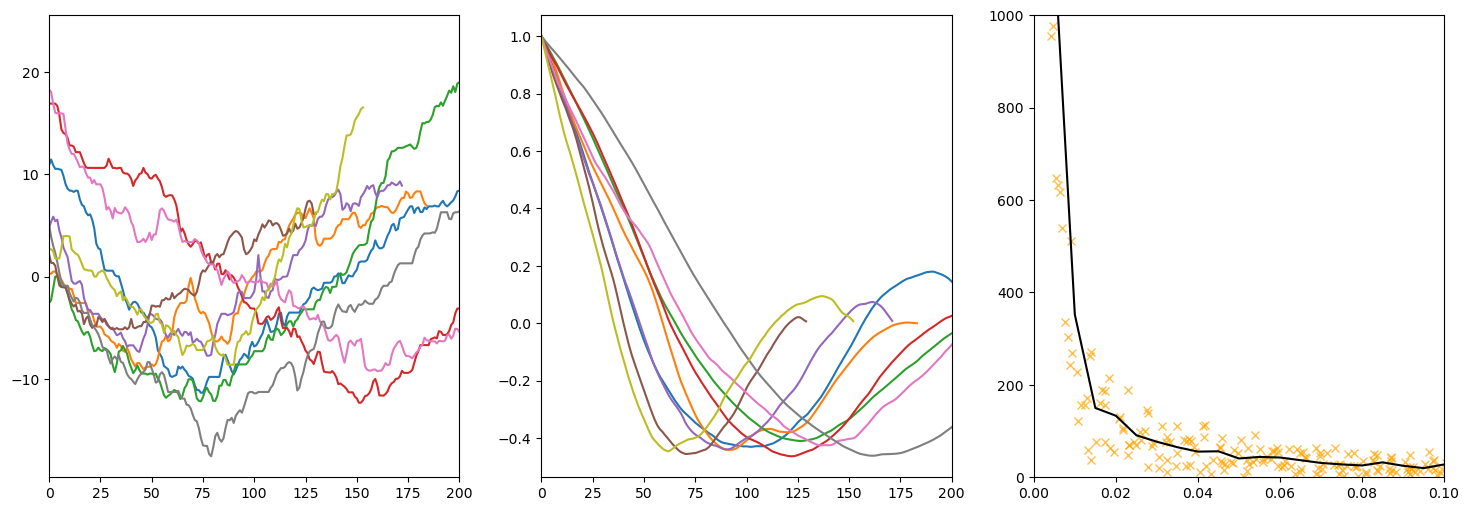

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

indices = [] 
theta_ks = [] 

for (n, stages) in enumerate(straight_segments): 
    phases = np.array(list(map(stage_to_phase, stages)))    
    
    shift(phases)
    theta_smooth = smooth(phases, 50)
    x = theta_smooth - np.mean(theta_smooth)
    axes[0].plot(x, color=plt.cm.tab10(n))
    
    L = len(theta_smooth)
    corr = np.correlate(x, x, mode='full')
    axes[1].plot(corr[L:]/corr[L], color=plt.cm.tab10(n))
    
    freq = np.fft.rfftfreq(L)[1:]
    indices.extend(np.digitize(freq, bins))
    theta_k = np.abs(np.fft.rfft(x))[1:]
    theta_ks.extend(theta_k)
    axes[2].plot(freq, theta_k, 'x', color='orange', alpha=0.7)
    

mtheta_k = average_scatter(np.array(indices), np.array(theta_ks))
axes[2].plot(mfreq, mtheta_k, color='k')

axes[0].set_xlim([0, 200])
axes[1].set_xlim([0, 200])
axes[2].set_xlim([0, 0.1])
axes[2].set_ylim([0, 1000])

## Perform inference on each tubule separately

In [23]:
def MAP(phi): 
    f = lambda x: cost(phi, x[0], x[1], x[2]) 
    bounds = ((-2, 2), (-np.pi, np.pi), (0, 1))
    res = minimize(f, (1, 0, 0), method='trust-constr', bounds=bounds)
    
    # brute(f, ((-1, 0), (-np.pi, np.pi), (0, 1)))
    return res

def get_MAP_sigma(phi, eta, grad, alpha):
    L = len(phi)+1
    phi = np.concatenate([[-grad], phi, [grad]])
    phi2 = phi[1:] + phi[:-1] 
    phi2 = np.concatenate([[-2*grad], phi2, [grad*2]])
    
    rhs = get_rhs(phi, phi2, eta, alpha) 
    overall_freq = np.sum(rhs)/L
    omegas = (rhs - overall_freq)[:-1]

    Cov = get_cov(L)
    invCov = np.linalg.inv(Cov)
    var = (omegas.T @ invCov @ omegas)/(L-1)
    return np.sqrt(var) 


def cost(phi, eta, grad, alpha): 
    L = len(phi)+1
    phi = np.concatenate([[-grad], phi, [grad]])
    phi2 = phi[1:] + phi[:-1] 
    phi2 = np.concatenate([[-2*grad], phi2, [grad*2]])
    
    rhs = get_rhs(phi, phi2, eta, alpha) 
    overall_freq = np.sum(rhs)/L
    omegas = (rhs - overall_freq)[:-1]

    Cov = get_cov(L)
    invCov = np.linalg.inv(Cov)
    var = (omegas.T @ invCov @ omegas)/(L-1)
    
    J = get_J(phi, phi2, eta, alpha)
    logdetJ = np.log(np.abs(np.linalg.det(J))) 
    
    logpdf = stats.multivariate_normal.logpdf(omegas, cov=Cov*var)

    return - logpdf - logdetJ


def get_cov(L): 
    cov = np.identity(L-1) 
    cov -= 1/L
    return cov 

def get_rhs(phi, phi2, eta, alpha): 
    NN = np.sin(phi[1:]) - np.sin(phi[:-1]) + eta*(2-np.cos(phi[1:])-np.cos(phi[:-1]))
    NNN = np.sin(phi2[2:]) - np.sin(phi2[:-2]) + eta*(2-np.cos(phi2[2:])-np.cos(phi2[:-2]))
    return NN + alpha*NNN   

def get_J(phi, phi2, eta, alpha):
    L = len(phi)-1
    J = np.zeros((L, L))
    diag = np.cos(phi[1:-1]) + eta*np.sin(phi[1:-1]) + alpha*(np.cos(phi2[2:-1])+eta*np.sin(phi2[2:-1]))
    np.fill_diagonal(J, np.append(diag, 0))
    for i in range(L):
        if i >= 1: 
            J[i, i-1] = - np.cos(phi[i]) + eta*np.sin(phi[i])
            J[i, i-1] += alpha*(-np.cos(phi2[i]) + eta*np.sin(phi2[i]))
        if i <= L-2: 
            J[i, i+1] = alpha*(np.cos(phi2[i+2]) + eta*np.sin(phi2[i+2]))
        if i >=2:
            J[i, i-2] = alpha*(-np.cos(phi2[i]) + eta*np.sin(phi2[i]))
    d_omega = np.sum(J, axis=0)/L
    J -= d_omega[np.newaxis, :] 
    return J[:-1, :-1]

Tubule ID:  1


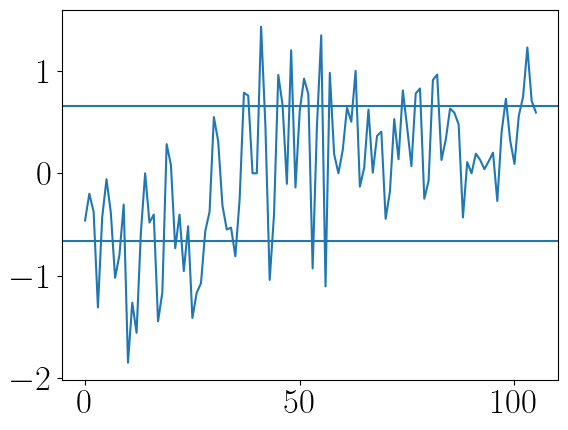

0.625579819902204 0.5071632130053474 0.012253919793762932 -2.5370669279963503e-06
Tubule ID:  2


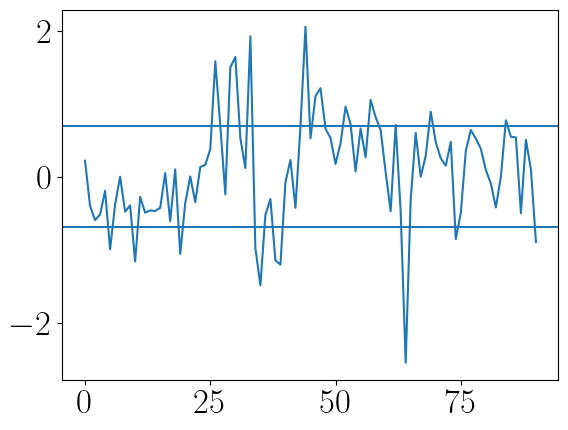

0.9412998503739435 0.8095777437102181 0.4316666912467619 0.02319217304003008
Tubule ID:  3


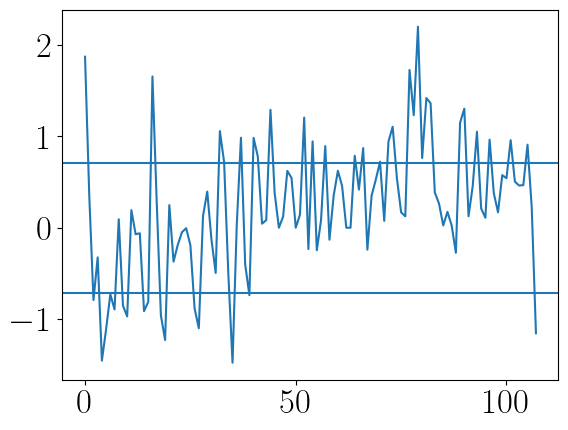

1.2113483591395433 1.0594275011290926 0.4004300042236978 -0.5154767967968317
Tubule ID:  4


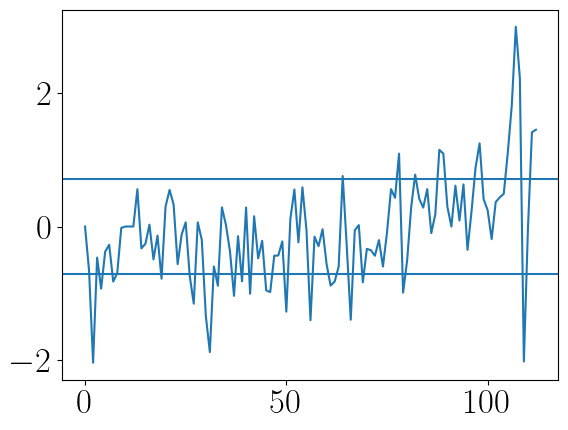

0.7716282572240987 0.1973928693477978 0.30459924773735053 0.3146991464063528
Tubule ID:  5


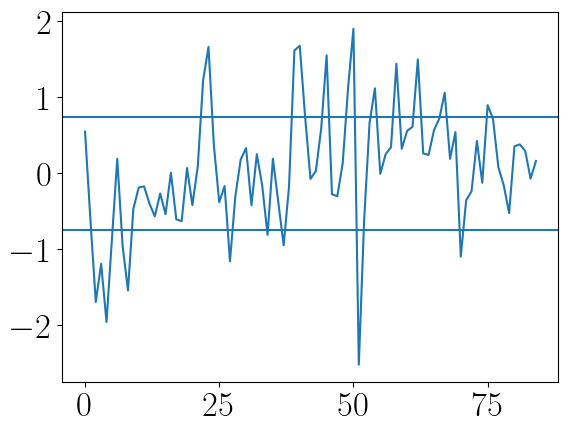

0.9716132851566313 0.013957987556421246 0.676258332221099 0.04801144015724713
Tubule ID:  6


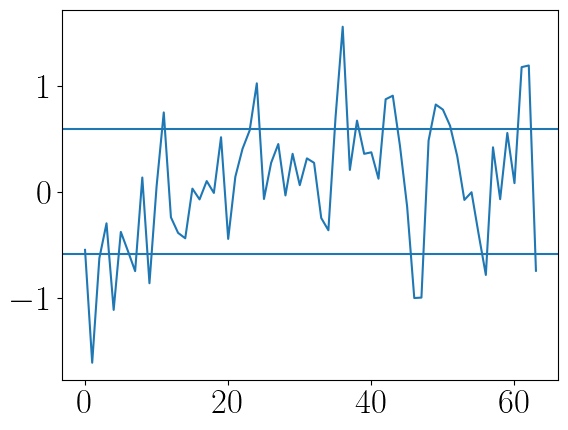

0.7574980748867578 0.981737089648296 0.17795122731142934 0.09203920081835971
Tubule ID:  7


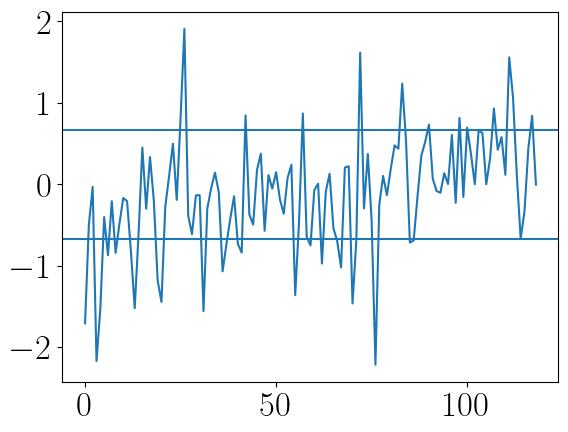

0.7564640307287243 0.9991123599620366 0.0011635056393591466 -0.00019710526427154832
Tubule ID:  8


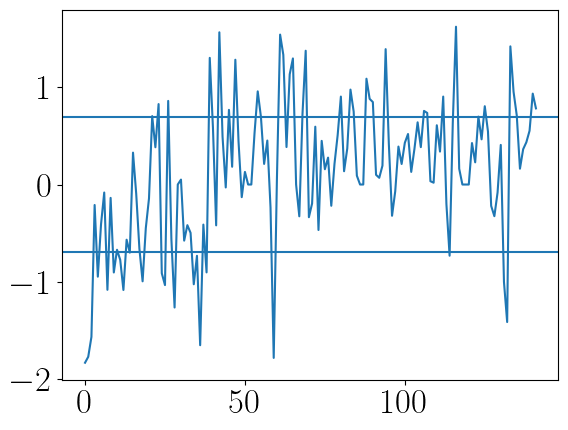

2.409416869489825 1.9999886127535955 0.8511571898636983 -3.006785475236571
Tubule ID:  9


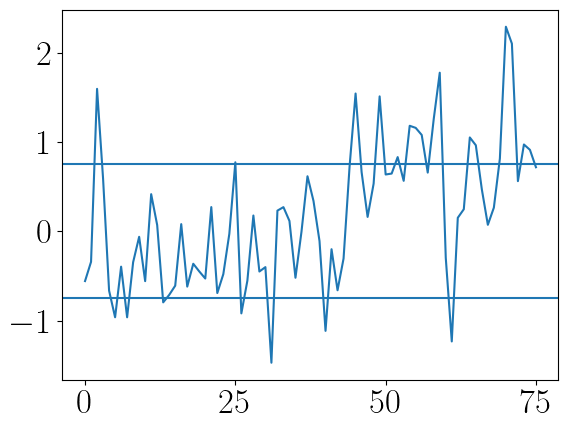

0.5848743394148203 0.3811736065323316 1.1005688824436135e-05 0.7161874342756778


In [24]:
etas = [] 
sigmas = [] 
grads = [] 
alphas = [] 
etas_err = [] 
sigmas_err = [] 
grads_err = [] 

plt.rc('font', size=25, family='serif')
plt.rc('text', usetex=True)

for (i, stages) in enumerate(straight_segments): 
    phases = np.array(list(map(stage_to_phase, stages)))
    shift(phases)
    theta_smooth = smooth(phases, 100)
#     theta_k = np.fft.rfft(theta_smooth)
#     theta_k[50:] = 0 
#     theta_smooth = np.fft.irfft(theta_k)
    
#     plt.plot(theta_smooth)
# plt.show() 
    
    print('Tubule ID: ', i+1)

    phi = theta_smooth[1:] - theta_smooth[:-1]
    plt.plot(phi)
    omega = np.mean(2*(1-np.cos(phi)))
    slope = np.sqrt(omega)
    plt.axhline(y=slope)
    plt.axhline(y=-slope)
    plt.show() 
    
    res = MAP(phi)
    eta, grad, alpha = res.x 
    sigma = get_MAP_sigma(phi, eta, grad, alpha)
    print(sigma, eta, alpha, grad) 
    # errs_hess = errors_hess(phi, eta, sigma, grad, diff=1e-4)
    
    # widths = np.copy(errs_hess)*10
    # widths[-1] = np.pi 
    # errs_brute = errors_brute(phi, eta, sigma, grad, diff=widths)
    # print('eta: ', eta, ', error: ', errs_hess[0], errs_brute[0])
    # print('sigma: ', sigma, ', error: ', errs_hess[1], errs_brute[1])
    # print('grad: ', grad, ', error: ', errs_hess[2], errs_brute[2])
    # plot_cost(phi, eta, sigma, grad, widths=widths)
    
    etas.append(eta)
    sigmas.append(sigma)
    grads.append(grad)
    alphas.append(alpha)
    # etas_err.append(errs_brute[0])
    # sigmas_err.append(errs_brute[1])
    # grads_err.append(errs_brute[2])
    
    
    

In [25]:
print(np.mean(etas), np.mean(sigmas), np.mean(alphas))

0.7721701092939042 1.003302542924061 0.3172767915251093


-132.90653908913063
-101.88140895832002
-146.31212202327953
-181.91365014180508
-137.93967132446784
-106.35006921726642
-191.6085792595351
-169.2368265280593
-126.93795384934634


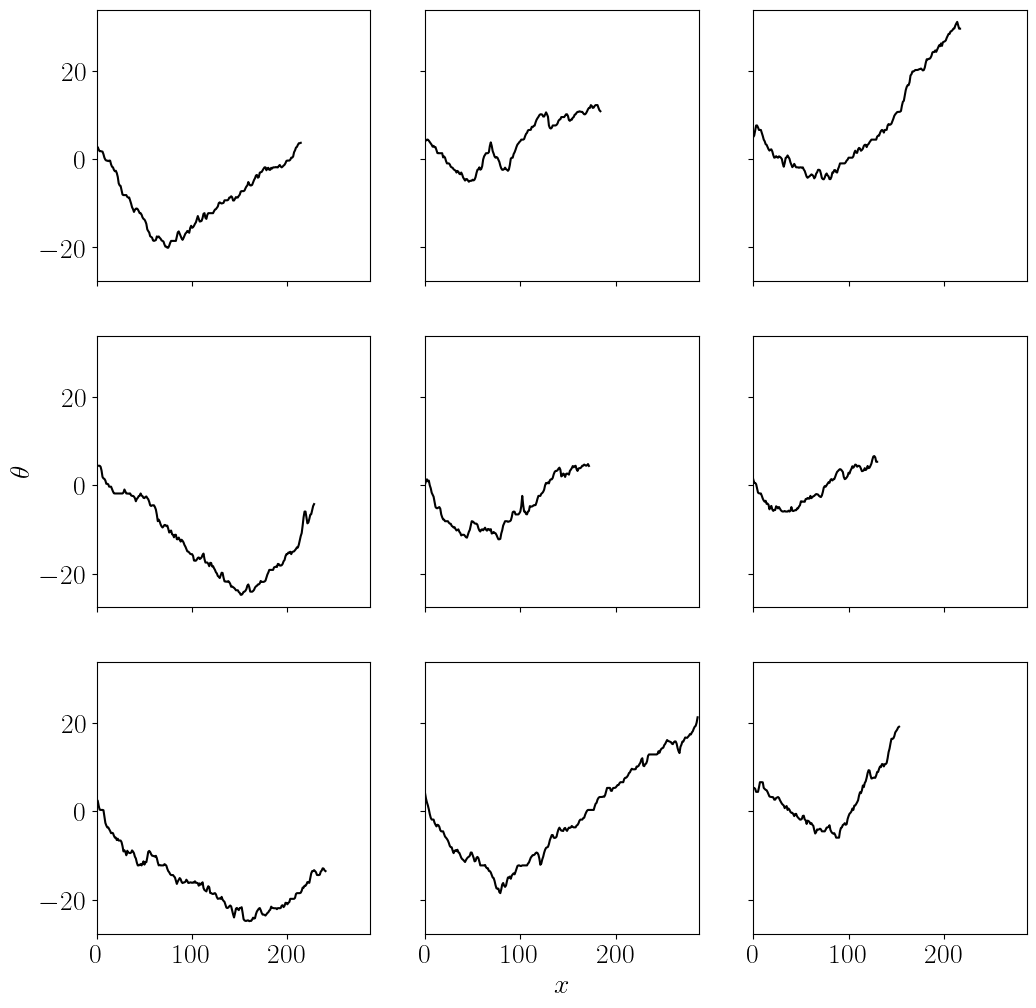

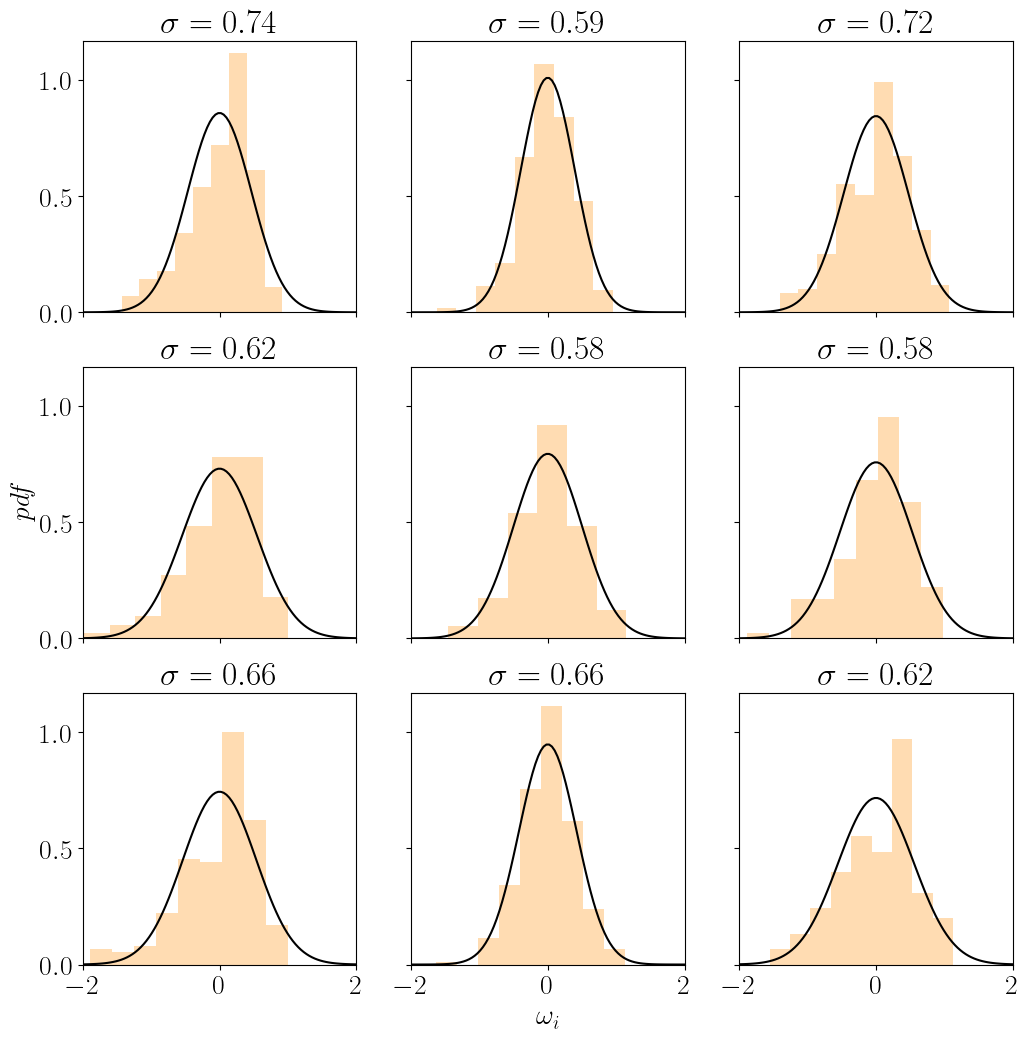

In [8]:
slopes = [] 

plt.rc('font', size=20)
fig1, axes1 = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 12))

fig2, axes2 = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 12))

l=0 

for (n, stages) in enumerate(straight_segments): 
    i, j = np.unravel_index(n, (3, 3))
    
    phases = np.array(list(map(stage_to_phase, stages)))
        
    
    shift(phases)
    theta_smooth = smooth(phases, 50)
    
    omega = np.mean(2*(1-np.cos(phi)))
    slope = np.sqrt(omega)
    slopes.append(slope)
    
    axes1[i, j].plot(theta_smooth, 'k-')
    l = max(l, len(theta_smooth))

    phi = theta_smooth[1:]-theta_smooth[:-1]


    BB, d = find_BB(phi, etas[j], grads[j])
    var, a = traj_logpdf(BB)

    print(a+np.log(d))

    omegas = BB[1:]-BB[:-1]

    axes2[i, j].hist(omegas, alpha=0.3, density=True, bins=9, color='darkorange')
    x = np.linspace(-2, 2, 100)
    axes2[i, j].set_title(r'$\sigma={:.2f}$'.format(sigmas[n]))
    axes2[i, j].plot(x, stats.norm.pdf(x, scale=np.sqrt(var)), color='black')


axes1[0, 0].set_xlim([0, l])    
axes1[2, 1].set_xlabel(r'$x$')
axes1[1, 0].set_ylabel(r'$\theta$')
fig1.savefig('omega_fit.pdf')

axes2[0, 0].set_xlim([-2, 2])
axes2[2, 1].set_xlabel(r'$\omega_i$')
axes2[1, 0].set_ylabel(r'$pdf$')
fig1.savefig('Figures/data.pdf')
fig2.savefig('Figures/omega_fit.pdf')
plt.show()

In [9]:
print('slope mean: ', np.mean(slopes))
print('slope std: ', np.std(slopes))

slope mean:  0.4890558184021454
slope std:  0.09627676865761015


mean eta:  -0.47430166718633526
mean sigma:  0.6396224142011628
mean grad:  0.2979116013258556


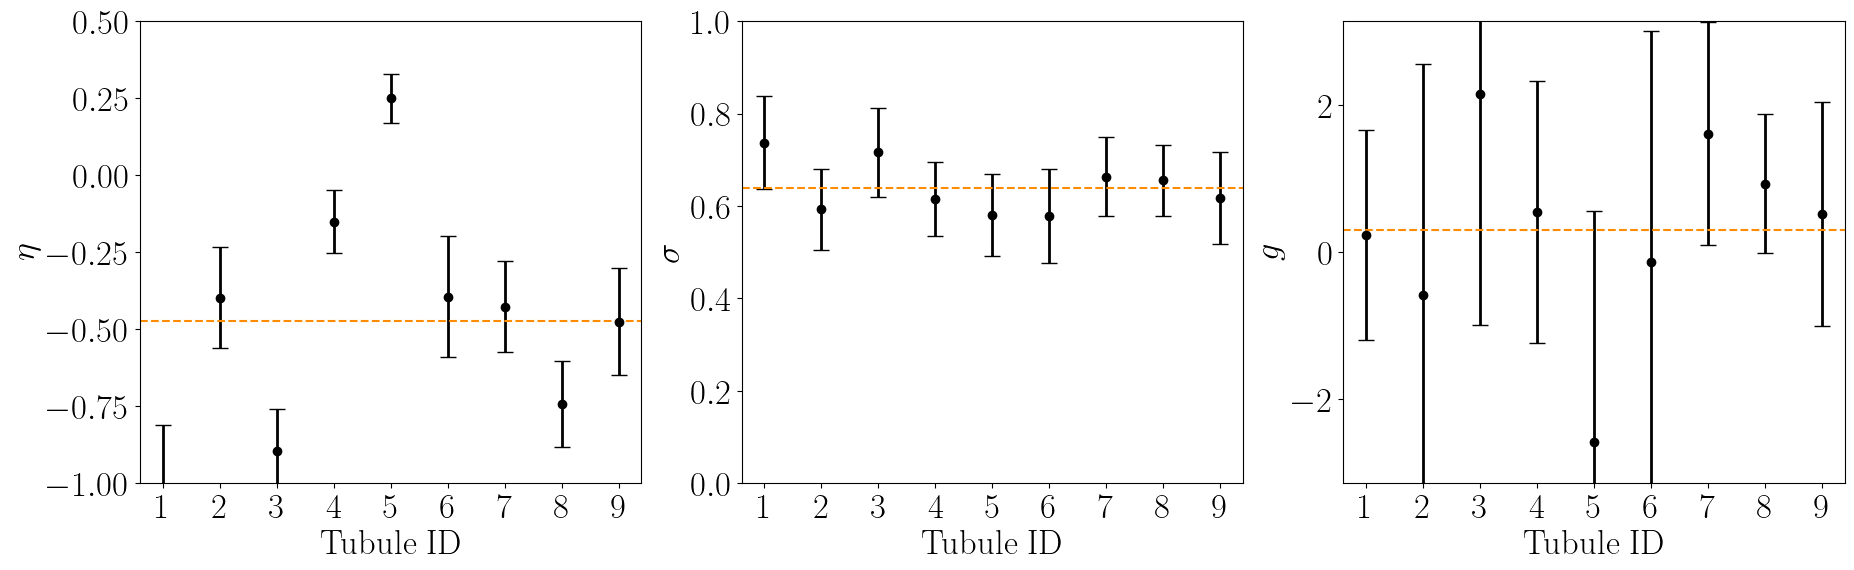

In [11]:
plt.rc('font', size=25)
plt.rc('text', usetex=True)

mean_eta = np.mean(etas)
mean_sigma = np.mean(sigmas)
mean_grad = np.mean(grads)

print('mean eta: ', mean_eta)
print('mean sigma: ', mean_sigma)
print('mean grad: ', mean_grad)

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(22, 6))
tubules = np.arange(1, 10)
axes[0].errorbar(tubules, etas, etas_err, fmt='o', linewidth=2, color='k', capsize=6)
axes[0].axhline(y=mean_eta, linestyle='--', color='darkorange')
axes[0].set_ylabel(r'$\eta$')
axes[0].set_xlabel(r'Tubule ID')
axes[0].set_xticks(np.arange(1, 10))
axes[0].set_ylim([-1, 0.5])

axes[1].errorbar(tubules, sigmas, sigmas_err, fmt='o', linewidth=2, color='k', capsize=6)
axes[1].axhline(y=mean_sigma, linestyle='--', color='darkorange')
axes[1].set_ylabel(r'$\sigma$')
axes[1].set_xlabel(r'Tubule ID')
axes[1].set_ylim([0, 1])

axes[2].errorbar(tubules, grads, grads_err, fmt='o', linewidth=2, color='k', capsize=6)
axes[2].axhline(y=mean_grad, linestyle='--', color='darkorange')
axes[2].set_ylabel(r'$g$')
axes[2].set_ylim([-np.pi, np.pi])
axes[2].set_xlabel(r'Tubule ID')

plt.savefig('Figures/tubules.pdf')
plt.show() 
